<a href="https://colab.research.google.com/github/mahadi0007/4.1-soft-computing/blob/Lab-(assignment)/170104102_exp_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/Colab Notebooks/soft assignment/assignment 2/'

Mounted at /content/drive


# Import Library

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

# Image To Pixel Conversion

In [ ]:
#Useful function
def createFileList(myDir, format='.png'):
  fileList = []
  for root, dirs, files in os.walk(myDir, topdown=False):
    for name in files:
      if name.endswith(format):
        fullName = os.path.join(root, name)
        fileList.append(fullName)
  return fileList

# load the original image
myFileList = createFileList(root_path)

for file in myFileList:
  img_file = Image.open(file)
  img_file = img_file.resize((28, 28))

  # Make image Greyscale
  img_grey = img_file.convert('L')

  # Save Greyscale values
  value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((img_grey.size[1], img_grey.size[0]))
  value = value.flatten()
  value = value.tolist()
  value.insert(0, os.path.basename(file))
  with open(root_path + "all_img_pixels.csv", 'a') as f:
    writer = csv.writer(f)
    writer.writerow(value)

In [ ]:
header_list = ['filename']
for x in range(1, 785):
  header_list.append('pixel'+str(x))

In [ ]:
df1 = pd.read_csv(root_path + 'Dataset A/training-a.csv')
df1 = df1[['filename', 'digit']]
df2 = pd.read_csv(root_path + "all_img_pixels.csv", names=header_list)

In [ ]:
df3 = pd.merge(df1,df2,on='filename')
df3 = df3.drop(columns=['filename'])
df3 = df3.rename(columns={"digit":"label"})


In [ ]:
X_data = df3.drop("label", axis=1).values.astype(np.uint8)
y_data = df3["label"].values

In [ ]:
def plot_sample_images(X, y, ncols, num):
  num = int(min(num, len(y)))
  nrows = math.ceil(num / ncols)
  fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols, nrows))
  fig.subplots_adjust(hspace=0.8)
  for i, ax in enumerate(axes.flatten()):
    if i < num:
      ax.imshow(X.max()-X[i].reshape(28, 28), cmap="gray")
      ax.set_title(str(y[i]))
    ax.axis('off')
  plt.show()

In [ ]:
plot_sample_images(X_data, y_data, ncols=10, num=100)

In [ ]:
df3.to_csv(root_path + 'final_data_with_pixels.csv', index=False)

# Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

# Train

In [ ]:
def train(train_dataset, test_dataset, experiment_number):
  # Hyperparameters

  batch_size = 20
  num_iters = 20000
  input_dim = 28*28 # num_features = 784
  num_hidden = 200 # num of hidden nodes
  output_dim = 10

  learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

  startingEpoch = 0
  iteration_loss = []
  iter = 0

  # Device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  X_data = train_dataset.drop("label", axis=1).values.astype(np.uint8)
  y_data = train_dataset["label"].values.astype(np.uint8)

  X_test = test_dataset.drop("label", axis=1).values.astype(np.uint8)
  y_test = test_dataset["label"].values.astype(np.uint8)

  class Digit_Recognizer_model(Dataset):
    def __init__(self, X, y, transforms):
      self.X = X
      self.y = y
      self.transforms = transforms

    def __len__(self):
      return self.X.shape[0]

    def __getitem__(self, idx):
      X = np.reshape(self.X[idx], (28, 28, 1))
      X = self.transforms(X)
      return X, self.y[idx]
  
  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ])

  train_dataset = Digit_Recognizer_model(X=X_data, y=y_data, transforms=transform_test)
  test_dataset = Digit_Recognizer_model(X=X_test, y=y_test, transforms=transform_test)

  num_epochs = num_iters / (len(train_dataset) / batch_size)
  num_epochs = int(num_epochs)

  # prepare loaders
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True)   # It's better to shuffle the whole training dataset! 

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False) 
  
  class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
      super().__init__()
      ### 1st hidden layer: 784 --> 200
      self.linear_1 = nn.Linear(input_size, num_hidden)
      ### Non-linearity in 1st hidden layer
      self.relu_1 = nn.ReLU()

      ### 2nd hidden layer: 200 --> 200
      self.linear_2 = nn.Linear(num_hidden, num_hidden)
      ### Non-linearity in 2nd hidden layer
      self.relu_2 = nn.ReLU()

      ### 3rd hidden layer: 200 --> 200
      self.linear_3 = nn.Linear(num_hidden, num_hidden)
      ### Non-linearity in 3rd hidden layer
      self.relu_3 = nn.ReLU()

      ### 4th hidden layer: 200 --> 200
      self.linear_4 = nn.Linear(num_hidden, num_hidden)
      ### Non-linearity in 4th hidden layer
      self.relu_4 = nn.ReLU()

      ### 5th hidden layer: 200 --> 200
      self.linear_5 = nn.Linear(num_hidden, num_hidden)
      ### Non-linearity in 5th hidden layer
      self.relu_5 = nn.ReLU()

      ### 6th hidden layer: 200 --> 200
      self.linear_6 = nn.Linear(num_hidden, num_hidden)
      ### Non-linearity in 6th hidden layer
      self.relu_6 = nn.ReLU()

      ### Output layer: 200 --> 10
      self.linear_out = nn.Linear(num_hidden, num_classes)   
      
    def forward(self, x):
      ### 1st hidden layer
      out  = self.linear_1(x)
      ### Non-linearity in 1st hidden layer
      out = self.relu_1(out)
          
      ### 2nd hidden layer
      out  = self.linear_2(out)
      ### Non-linearity in 2nd hidden layer
      out = self.relu_2(out)

      ### 3rd hidden layer
      out  = self.linear_3(out)
      ### Non-linearity in 3rd hidden layer
      out = self.relu_3(out)

      ### 4th hidden layer
      out  = self.linear_4(out)
      ### Non-linearity in 4th hidden layer
      out = self.relu_4(out)

      ### 5th hidden layer
      out  = self.linear_5(out)
      ### Non-linearity in 5th hidden layer
      out = self.relu_5(out)

      ### 6th hidden layer
      out  = self.linear_6(out)
      ### Non-linearity in 6th hidden layer
      out = self.relu_6(out)
          
      # Linear layer (output)
      probas  = self.linear_out(out)
      return probas
     
  '''
  INSTANTIATE MODEL CLASS
  '''
  model = DeepNeuralNetworkModel(input_size = input_dim,
                                num_classes = output_dim,
                                num_hidden = num_hidden)
  # To enable GPU
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  if experiment_number == 1 and os.path.isfile(root_path + 'soft_computing_Experiment1_Checkpoint1.pth.tar'):
    checkpoint = torch.load(root_path + 'soft_computing_Experiment1_Checkpoint1.pth.tar')
    print("--> Loading checkpoint : ")
    print(str(checkpoint['iter'])+' iteration completed: ')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    startingEpoch = checkpoint['epoch']
    iteration_loss = checkpoint['iteration_loss']
    iter = checkpoint['iter']
    model.train()
  elif experiment_number == 2 and os.path.isfile(root_path + 'soft_computing_Experiment1_Checkpoint2.pth.tar'):
    checkpoint = torch.load(root_path + 'soft_computing_Experiment1_Checkpoint2.pth.tar')
    print("--> Loading checkpoint : ")
    print(str(checkpoint['iter'])+' iteration completed: ')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    startingEpoch = checkpoint['epoch']
    iteration_loss = checkpoint['iteration_loss']
    iter = checkpoint['iter']
    model.train()

  if startingEpoch + 1 < num_epochs:
    print('Starting_Epoch: '+ str(startingEpoch + 1))
    for epoch in range(startingEpoch, num_epochs):      
      for i, (images, labels) in enumerate(train_loader):
        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device).type(torch.LongTensor)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images).cpu()

        # Calculate Loss: softmax --> cross entropy loss
  
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
          # Calculate Accuracy         
          correct = 0
          total = 0
          # Iterate through test dataset
          for images, labels in test_loader:
            
            images = images.view(-1, 28*28).to(device)

            # Forward pass only to get logits/output
            outputs = model(images)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs, 1)

            # Total number of labels
            total += labels.size(0)


            # Total correct predictions
            if torch.cuda.is_available():
              correct += (predicted.cpu() == labels.cpu()).sum() 
            else:
              correct += (predicted == labels).sum()

          accuracy = 100 * correct.item() / total
          
          # Print Loss
          iteration_loss.append(loss.item())
          print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

      checkpoint = {'epoch': epoch, 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    'iteration_loss': iteration_loss,
                    'iter': iter}
      print("=> Saving checkpoint of epoch " + str(epoch + 1))
      if experiment_number == 1:
        torch.save(checkpoint, root_path + 'soft_computing_Experiment1_Checkpoint1.pth.tar')
      elif experiment_number == 2:
        torch.save(checkpoint, root_path + 'soft_computing_Experiment1_Checkpoint2.pth.tar')
  else:
    print('Training finish')

  plt.title("Loss vs Iteration")
  plt.plot(iteration_loss)
  plt.ylabel('Cross Entropy Loss')
  plt.xlabel('Iteration (in every 500)')
  plt.show()

  save_model = True

  if save_model is True and experiment_number == 1:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'soft_computing_Experiment1_NN1.pkl')
  elif save_model is True and experiment_number == 2:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'soft_computing_Experiment1_NN2.pkl')

  load_model = True

  if load_model is True and experiment_number == 1:
    model.load_state_dict(torch.load(root_path + 'soft_computing_Experiment1_NN1.pkl'))
    print('Trained Model Loaded')
  elif load_model is True and experiment_number == 2:
    model.load_state_dict(torch.load(root_path + 'soft_computing_Experiment1_NN2.pkl'))
    print('Trained Model Loaded')

  y_pred = torch.tensor([], dtype=torch.int32)
  y_true = torch.tensor([], dtype=torch.int32)
  for i, (images, labels) in enumerate(test_loader):
    images = images.view(-1, 28*28).to(device)
    labels = labels.to(device)

    # Forward pass only to get logits/output
    outputs = model(images).cpu()

    # Get predictions from the maximum value
    _, predictions = torch.max(outputs, 1)
    y_pred = torch.cat((y_pred, predictions.cpu()), dim = 0)
    y_true = torch.cat((y_true.cpu(), labels.cpu()), dim = 0).to(device)


  print('Accuracy: ' +str(round(accuracy_score(y_true.cpu(), y_pred) * 100, 4)))
  print('Precision: ' +str(round(precision_score(y_true.cpu(), y_pred, average='micro') * 100, 4)))
  print('Recall: ' +str(round(recall_score(y_true.cpu(), y_pred, average='micro') * 100, 4)))
  print('F1 score: ' +str(round(f1_score(y_true.cpu(), y_pred, average='micro')  * 100, 4)))
  confusion_mtx = confusion_matrix(y_true.cpu(), y_pred)
  plot_confusion_matrix(confusion_mtx, classes = range(10))

# Model 1
final_data_with_pixels

In [ ]:
df = pd.read_csv(root_path + 'Dataset A/final_data_with_pixels.csv')

In [ ]:
train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=42)

Starting_Epoch: 1
Iteration: 500. Loss: 2.2984025478363037. Accuracy: 10.022836843440752
=> Saving checkpoint of epoch 1
Iteration: 1000. Loss: 2.3083930015563965. Accuracy: 9.261608728749048
Iteration: 1500. Loss: 2.3065993785858154. Accuracy: 10.301953818827709
=> Saving checkpoint of epoch 2
Iteration: 2000. Loss: 2.3084912300109863. Accuracy: 10.504947982745495
=> Saving checkpoint of epoch 3
Iteration: 2500. Loss: 2.3056604862213135. Accuracy: 10.022836843440752
Iteration: 3000. Loss: 2.303392171859741. Accuracy: 9.083988835320984
=> Saving checkpoint of epoch 4
Iteration: 3500. Loss: 2.3015148639678955. Accuracy: 9.515351433646282
=> Saving checkpoint of epoch 5
Iteration: 4000. Loss: 2.303802013397217. Accuracy: 10.022836843440752
Iteration: 4500. Loss: 2.30273175239563. Accuracy: 10.022836843440752
=> Saving checkpoint of epoch 6
Iteration: 5000. Loss: 2.3118948936462402. Accuracy: 10.504947982745495
Iteration: 5500. Loss: 2.321913242340088. Accuracy: 10.403450900786602
=> Savi

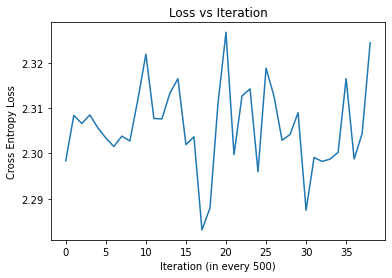

Trained Model Loaded
Accuracy: 10.0228
Precision: 10.0228
Recall: 10.0228
F1 score: 10.0228


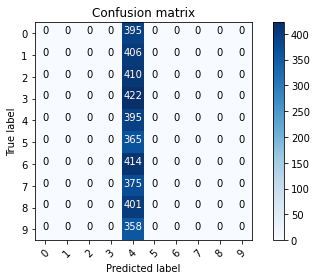

In [ ]:
train(train_dataset, test_dataset, 1)

# Model 2
MNIST

In [ ]:
train_dataset = pd.read_csv(root_path + "Dataset_2/verification_train.csv")
test_dataset = pd.read_csv(root_path + "Dataset_2/verification_test.csv")

Starting_Epoch: 1
Iteration: 500. Loss: 1.3170307874679565. Accuracy: 55.46
Iteration: 1000. Loss: 1.2631938457489014. Accuracy: 48.91
Iteration: 1500. Loss: 1.4589533805847168. Accuracy: 33.57
Iteration: 2000. Loss: 1.2840017080307007. Accuracy: 38.47
Iteration: 2500. Loss: 1.8389050960540771. Accuracy: 34.53
Iteration: 3000. Loss: 1.5127242803573608. Accuracy: 46.77
=> Saving checkpoint of epoch 1
Iteration: 3500. Loss: 1.1430498361587524. Accuracy: 54.08
Iteration: 4000. Loss: 2.1632628440856934. Accuracy: 10.0
Iteration: 4500. Loss: 2.3846869468688965. Accuracy: 10.0
Iteration: 5000. Loss: 2.3204524517059326. Accuracy: 10.0
Iteration: 5500. Loss: 2.3303771018981934. Accuracy: 10.0
Iteration: 6000. Loss: 2.3815579414367676. Accuracy: 10.0
=> Saving checkpoint of epoch 2
Iteration: 6500. Loss: 2.297973871231079. Accuracy: 9.99
Iteration: 7000. Loss: 2.3741369247436523. Accuracy: 10.0
Iteration: 7500. Loss: 2.3400373458862305. Accuracy: 10.0
Iteration: 8000. Loss: 2.2859530448913574. 

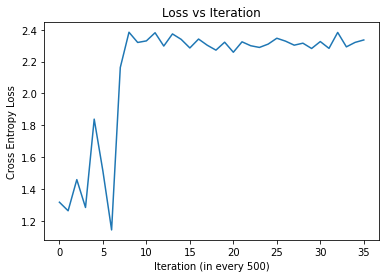

Trained Model Loaded
Accuracy: 10.0
Precision: 10.0
Recall: 10.0
F1 score: 10.0


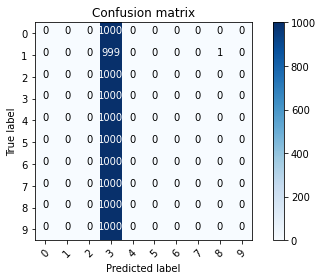

In [ ]:
train(train_dataset, test_dataset, 2)